In [493]:

import numpy.linalg as la
from cvxopt import solvers, matrix
import cvxpy as cp
import os
import numpy as np
from math import *
import matplotlib.pyplot as plt



class qp_solver():
    def __init__(self,alpha=0.8,beta=0.8,mu=8,eps=1e-8):
        self.alpha = alpha
        self.beta = beta
        self.mu = mu
        self.eps = eps
        self.P = None
        self.q = None
        self.A = None
        self.b = None
        self.G = None
        self.h = None
    
        self.sol = None
        self.opt_val = None
        self.iterations = []

    def find_feasible_point(self):
        y = self.A.T
        c1_indices = y == 1
        c2_indices = y == -1
        c1_count = c1_indices.sum()
        c2_count = c2_indices.sum()

        x = np.zeros((len(y),1))
        C = max(self.h)
        x[c1_indices] = C/c1_count
        x[c2_indices] = C/c2_count

        # return la.lstsq(self.A,self.b,rcond = None)[0]
        return x

    def evaluate_obj(self,x):
        return 0.5*x.T@self.P@x + self.q.T@x

    def evaluate_barrier(self,x):
        return -self.mu*((np.log(-(self.G@x-self.h))).sum())

    def newton_minimization(self,x,tol=1e-5):
        m = self.G.shape[0]
        n = self.G.shape[1]
        tt = 1
        # print(hess_barrier.shape)
        tol_optimal = False
        hess_obj = self.P
        
        while not tol_optimal:    
            grad_obj = (self.P@x + self.q)
            grad_barrier = self.mu*(self.G.T@(-1/(self.G@x-self.h)))
            hess_barrier = np.zeros((m,m))
            np.fill_diagonal(hess_barrier,1/(self.G@x-self.h)**2)
            hess_barrier = self.mu*(self.G.T@hess_barrier@self.G)        
            
            #solve kkt matrix
            H = hess_obj + hess_barrier
            g = grad_obj + grad_barrier
            KKT = np.hstack((np.vstack((H,self.A)), np.vstack((self.A.T,np.array([0])))))
            v = la.lstsq(KKT,np.vstack((-g, np.array([0]))),rcond = None)[0][0:n]

            L = g.T@v
            if (-L/2 <= tol):
                tol_optimal = True

            #backtracking line search
            tt = 1   
            old_value = self.evaluate_obj(x) + self.evaluate_barrier(x)  
            while(self.evaluate_obj(x+tt*v) + self.evaluate_barrier(x+tt*v)
            >old_value + 0.01*tt*L):
                tt *= self.beta
            
            new_value = self.evaluate_obj(x+tt*v) + self.evaluate_barrier(x+tt*v)
            self.iterations.append(new_value)
            x += tt*v

            if (abs(new_value - old_value)<tol):
                break

            print("objective function + barrier value: ",new_value)
            

            
        return x
    
    
    def solve(self,P,q,A,b,G,h):
        self.P = P
        self.q = q
        self.A = A
        self.b = b
        self.G = G
        self.h = h.reshape(-1,1)

        m = G.shape[0]
        t = 1
        x = self.find_feasible_point()
        # print(x.shape)
        eps_optimal = False
        while not eps_optimal:
            x = self.newton_minimization(x)

            if (m*self.mu<self.eps):
                eps_optimal = True

            else:
                self.mu *= self.alpha

        self.sol = x
        self.opt_val = self.evaluate_obj(x)
        





def kernel(xi, xj, gamma):
    return exp(-1*gamma*(np.linalg.norm(xi-xj)**2))

class svm:
    def __init__(self,gamma,C):
        self.gamma = gamma
        self.C = C
        self.w = None
        self.b = None
        self.support_indices = None
        self.support_count = None
        self.opt_value = None
        self.x_train = None
        self.y_train = None
        self.alpha = None
        self.samples_count = None
        self.iterations = None

    def fit(self,x,y,solver='cvx'):
        self.x_train = x
        self.y_train = y
        self.samples_count = len(y)

        gamma = self.gamma
        C = self.C
        n = x.shape[0]
        y_diag = np.zeros((n,n))
        np.fill_diagonal(y_diag, np.array(y))
        K = np.zeros((n,n))

        K = np.exp(-1*self.gamma*((np.linalg.norm(x, axis=1)**2).reshape(-1,1) + (np.linalg.norm(x.T, axis=0)**2).reshape(1,-1) - 2*x@x.T))

        P = y_diag@K@y_diag.T
        q = np.ones((n,1))
        h = np.hstack((C*np.ones(n), np.zeros(n)))
        G = np.vstack((np.eye(n),-1*np.eye(n)))    
        A = y.reshape(1,-1)
        b = np.zeros((1))
        

        
        if (solver == 'barrier'):
            solver = qp_solver()
            solver.solve(P,-q,A,b,G,h)
            a = solver.sol
            dd = np.array(a).reshape(-1,1)
            self.opt_value = solver.opt_val

        else:
            P = cp.atoms.affine.wraps.psd_wrap(P)
            a = cp.Variable(n)
            prob = cp.Problem(cp.Maximize((-1/2)*cp.quad_form(a, P) + q.T @ a), [G @ a <= h, A @ a == b])
            prob.solve()
            dd = np.array(a.value).reshape(-1,1)
            self.opt_value = prob.value        
        
        self.alpha = dd
        w = (((y.reshape(-1,1) * dd.reshape(-1,1)).T)@x).reshape(-1,1)
        S1 = np.where(dd>1e-4)[0]
        S = np.where((dd>1e-4) & (dd<C-1e-4))[0]
        x_new = self.x_train[S,:][0].reshape(-1,1)
        y_new = self.y_train[S][0]

        self.support_indices = S1
        self.support_count = len(S1)
        self.w = w

        
        kernel_vector = np.zeros((n,1))
        for i in range(n):
            kernel_vector[i] = kernel(x[i,:].reshape(-1,1), x_new, gamma = self.gamma)

        self.b = y_new - ((y.reshape(-1,1) * dd.reshape(-1,1)).T)@kernel_vector


    def return_parms(self):
        return self.w, self.b

    def color_plot(self, x_range, y_range):
        points_count = 200
        x = np.linspace(x_range[0], x_range[1], points_count)
        y = np.linspace(y_range[0], y_range[1], points_count)
        
        Y = np.zeros((len(y), len(x)))
        for i in range(len(y)):
            for j in range(len(x)):
                Y[i,j] = self.predict(np.array([x[j],y[i]]).reshape(-1,1))

        plt.contour(x,y,Y,levels = [0])
        c1_index = np.where(self.y_train == -1)
        c2_index = np.where(self.y_train == 1)
        plt.scatter(self.x_train[c1_index,0],self.x_train[c1_index,1],color = 'r')
        plt.scatter(self.x_train[c2_index,0],self.x_train[c2_index,1],color = 'b')

        #plot support vectors
        # plt.scatter(self.x_train[self.support_indices,0],self.x_train[self.support_indices,1],color='y')

        plt.axis('scaled')
        # plt.colorbar()
        plt.show()
        

    def predict(self, x_new, c = True):
        train_norm = np.linalg.norm(self.x_train, axis = 1)
        test_norm = np.linalg.norm(x_new)
        prediction = self.b + ((self.alpha.reshape(-1,1)*self.y_train).reshape(1,-1))@(np.exp(-1*self.gamma*((train_norm.reshape(-1,1))**2 + test_norm**2 
        - (2*self.x_train@x_new)).reshape(-1,1)))
        if c:
            return  np.sign(prediction)
        return prediction

    

x = np.array([])
data_path = os.path.join(os.getcwd(), 'svm_train.txt')
x = np.loadtxt(data_path)
y = x[:,2]
x = x[:,0:2]

y = y.reshape((-1,1))  


C :  0.01  Gamma :  10
Optimal Objective Value of The Dual Problem:  7.130305414357996
Number of Support Vectors:  768


C:\Users\amirm\AppData\Local\Temp\ipykernel_18100\3166810967.py:215: UserWarning: No contour levels were found within the data range.
  plt.contour(x,y,Y,levels = [0])


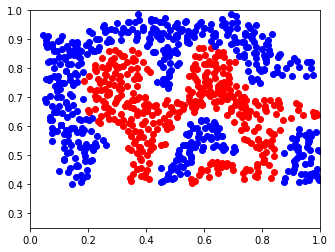

C :  0.01  Gamma :  50
Optimal Objective Value of The Dual Problem:  6.716281942045255
Number of Support Vectors:  770


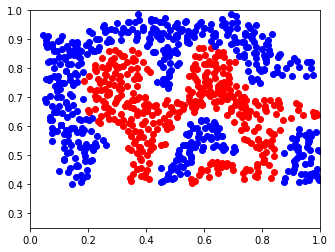

C :  0.01  Gamma :  100
Optimal Objective Value of The Dual Problem:  6.794814817125538
Number of Support Vectors:  771


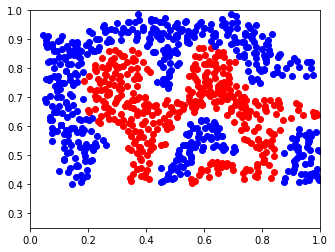

C :  0.01  Gamma :  500
Optimal Objective Value of The Dual Problem:  7.306473921076104
Number of Support Vectors:  797


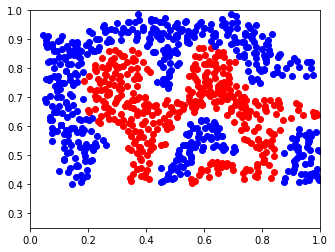

C :  0.1  Gamma :  10
Optimal Objective Value of The Dual Problem:  49.480754242458005
Number of Support Vectors:  584


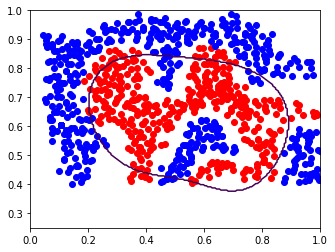

C :  0.1  Gamma :  50
Optimal Objective Value of The Dual Problem:  31.260609327914516
Number of Support Vectors:  448


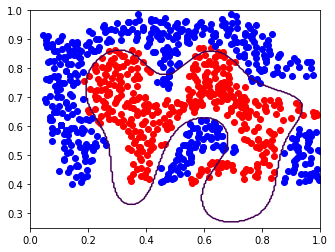

C :  0.1  Gamma :  100
Optimal Objective Value of The Dual Problem:  28.374182094853083
Number of Support Vectors:  449


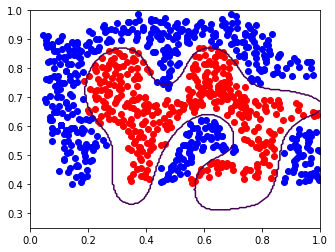

C :  0.1  Gamma :  500
Optimal Objective Value of The Dual Problem:  42.417466421595186
Number of Support Vectors:  744


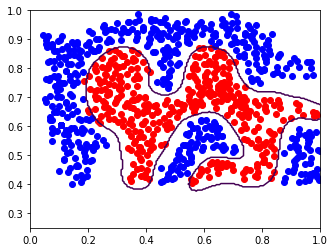

C :  0.5  Gamma :  10
Optimal Objective Value of The Dual Problem:  187.56122296703327
Number of Support Vectors:  447


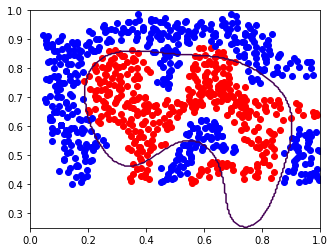

C :  0.5  Gamma :  50
Optimal Objective Value of The Dual Problem:  79.70705417552585
Number of Support Vectors:  249


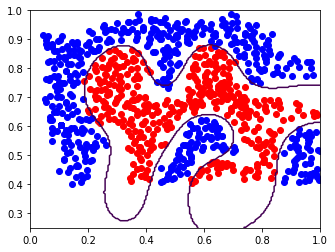

C :  0.5  Gamma :  100
Optimal Objective Value of The Dual Problem:  60.780377587938816
Number of Support Vectors:  210


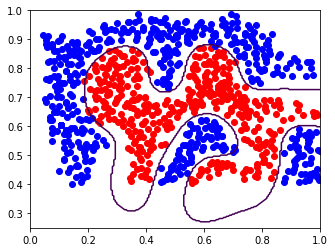

C :  0.5  Gamma :  500
Optimal Objective Value of The Dual Problem:  64.36483619001926
Number of Support Vectors:  346


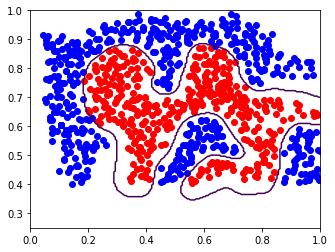

C :  1  Gamma :  10
Optimal Objective Value of The Dual Problem:  326.34207201558627
Number of Support Vectors:  401


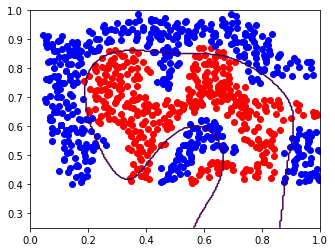

C :  1  Gamma :  50
Optimal Objective Value of The Dual Problem:  116.6115340925346
Number of Support Vectors:  185


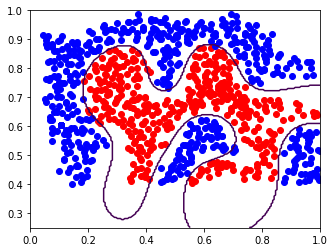

C :  1  Gamma :  100
Optimal Objective Value of The Dual Problem:  83.41143630372153
Number of Support Vectors:  157


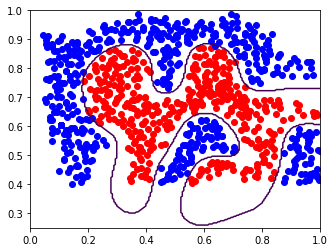

C :  1  Gamma :  500
Optimal Objective Value of The Dual Problem:  73.96326457109004
Number of Support Vectors:  282


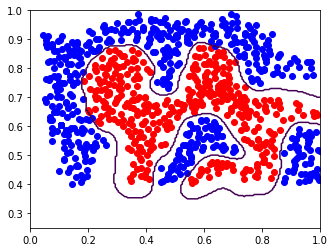

In [411]:
C_arr = [0.01,0.1, 0.5,1]
gamma_arr = [10,50,100,500]

for C in C_arr:
    for gamma in gamma_arr:
        model = svm(gamma,C)
        model.fit(x,y,solver='cvx')
        print("C : ", C, " Gamma : ", gamma)
        print("Optimal Objective Value of The Dual Problem: ",model.opt_value)
        print("Number of Support Vectors: ",model.support_count)
        model.color_plot((0,1), (0.25,1))

objective function + barrier value:  [[68980.30683575]]
objective function + barrier value:  [[64242.41771347]]
objective function + barrier value:  [[59552.410886]]
objective function + barrier value:  [[54958.98359663]]
objective function + barrier value:  [[50561.70770679]]
objective function + barrier value:  [[46566.27979701]]
objective function + barrier value:  [[43389.20825145]]
objective function + barrier value:  [[41689.22424679]]
objective function + barrier value:  [[41422.83518631]]
objective function + barrier value:  [[41421.75014748]]
objective function + barrier value:  [[33131.17690199]]
objective function + barrier value:  [[26498.71651404]]
objective function + barrier value:  [[21192.74596649]]
objective function + barrier value:  [[16947.96673616]]
objective function + barrier value:  [[13552.13986816]]
objective function + barrier value:  [[10835.47402937]]
objective function + barrier value:  [[8662.13594395]]
objective function + barrier value:  [[6923.4587327

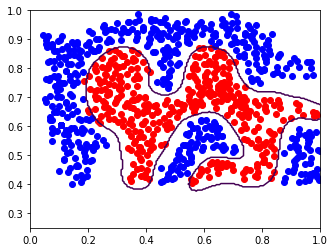

In [495]:
#Barrier Method
C = 0.1
gamma = 500

model = svm(gamma,C)
model.fit(x,y,solver='barrier')    
print("C : ", C, " Gamma : ", gamma)
print("Optimal Objective Value of The Dual Problem: ",model.opt_value)
print("Number of Support Vectors: ",model.support_count)
model.color_plot((0,1), (0.25,1))